# ResNet模型

# 检查版本

In [1]:
import torch
torch.version.cuda

'11.7'

In [2]:
import torch # 如果pytorch安装成功即可导入
print(torch.cuda.is_available()) # 查看CUDA是否可用
print(torch.cuda.device_count()) # 查看可用的CUDA数量
print(torch.version.cuda) # 查看CUDA的版本号
print(torch.__version__)

True
1
11.7
2.0.0+cu117


# 1.导入库

In [3]:
import os
import math
import argparse
import sys
import json
import pickle
import random

#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from functools import partial
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

print(1)



1


# 2.导入数据集和数据预处理

### 2.1定义导入数据集的模型

In [4]:
class MyDataSet(Dataset):
    """自定义数据集"""

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path   # 图片路径列表
        self.images_class = images_class  # 图片对应的类别
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])  # 打开图片
        # RGB为彩色图片，L为灰度图片
        if img.mode != 'RGB':  # 判断图片是否为RGB模式
            img = img.convert('RGB')  #不是RGB则转换为RGB图像
            #raise ValueError("image: {} isn't RGB mode.".format(self.images_path[item]))
        label = self.images_class[item]  # 获取图片对应的标签

        if self.transform is not None:
            img = self.transform(img)   # 对图片进行预处理

        return img, label

    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))   # 按照batch进行打包

        images = torch.stack(images, dim=0)   # 将batch中的图片张量叠起来
        labels = torch.as_tensor(labels)      # 将batch中的标签转换为张量
        return images, labels
    
print(1)

1


* 数据集分割函数用于划分训练集和测试集

In [5]:
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)  # 保证随机结果可复现
    assert os.path.exists(root), "dataset root: {} does not exist.".format(root) #检测指定路径是否存在数据集，不存在则抛出异常并打印错误信息。

    # 遍历文件夹，一个文件夹对应一个类别，class缩写
    #保存['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    # 排序，保证顺序一致
    flower_class.sort()
    # 生成类别名称以及对应的数字索引，`v` 表示类别名称， `k` 表示该类别对应的数字标签。"0": "daisy","1": "dandelion",
    class_indices = dict((k, v) for v, k in enumerate(flower_class))
    json_str = json.dumps(dict((val, key) for key, val in class_indices.items()), indent=4)
    #将类别名称映射为数字标签的字典保存到 JSON 文件 class_indices.json 中。写入模式 'w' 打开文件
    with open('class_indices.json', 'w') as json_file:  
        json_file.write(json_str)

    train_images_path = []  # 存储训练集的所有图片路径
    train_images_label = []  # 存储训练集图片对应索引信息
    val_images_path = []  # 存储验证集的所有图片路径
    val_images_label = []  # 存储验证集图片对应索引信息
    every_class_num = []  # 存储每个类别的样本总数
    supported = [".jpg", ".JPG", ".png", ".PNG"]  # 支持的文件后缀类型
    # 遍历每个文件夹下的文件
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        # 遍历获取supported支持的所有文件路径
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        # 获取该类别对应的索引
        image_class = class_indices[cla]
        # 记录该类别的样本数量
        every_class_num.append(len(images))
        # 按比例随机采样验证样本
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  # 如果该路径在采样的验证集样本中则存入验证集
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  # 否则存入训练集
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    print("{} images were found in the dataset.".format(sum(every_class_num))) #输出数据集中的图像数量和训练/验证集中的图像数量
    print("{} images for training.".format(len(train_images_path)))
    print("{} images for validation.".format(len(val_images_path)))

    plot_image = True   #False
    if plot_image:
        # 绘制每种类别个数柱状图
        plt.bar(range(len(flower_class)), every_class_num, align='center')
        # 将横坐标0,1,2,3,4替换为相应的类别名称
        plt.xticks(range(len(flower_class)), flower_class)
        # 在柱状图上添加数值标签
        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v + 5, s=str(v), ha='center')
        # 设置x坐标
        plt.xlabel('image class')
        # 设置y坐标
        plt.ylabel('number of images')
        # 设置柱状图的标题
        plt.title('flower class distribution')
        plt.show()

    return train_images_path, train_images_label, val_images_path, val_images_label

print(1)

1


### 2.2 导入数据集

In [6]:
#设置数据集的参数
data_path = "./data"
batch_size = 8   #  一次读取的样本数量

21165 images were found in the dataset.
16933 images for training.
4232 images for validation.


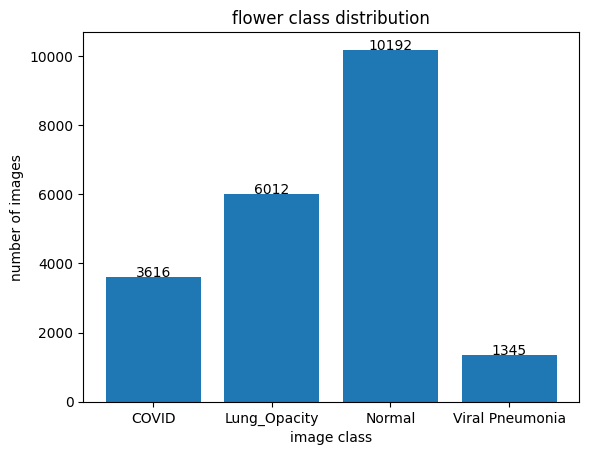

In [13]:
# 读取训练集和验证集图像路径及标签
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data(data_path)

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation((-45, 45)),  # Added Random Rotation
                                 transforms.ColorJitter(brightness=0.5),  # Added Brightness Adjustment
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}

train_dataset = MyDataSet(images_path=train_images_path,
                              images_class=train_images_label,
                              transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=0,
                                               collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=0,
                                             collate_fn=val_dataset.collate_fn)
print(1)

1


# 3.构建神经网络模型

### 3.1CNN模型

In [15]:
import torchvision.models as models

# 加载预训练的ResNet50模型
resnet50 = models.resnet50()

# 如果你的任务只有4个类别，你可能需要更改最后一层，以匹配你的类别数量
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)





# 4.配置模型

In [16]:
# 在模型选择这一步，选择ResNet模型
create_model = resnet50
print(1)

1


In [17]:
# 配置参数
#weights = "./vit_base_patch16_224_in21k.pth"
device = "cuda:0"
freeze_layers = True
lr = 0.001
lrf = 0.01
epochs = 50

In [18]:
# 选择设备：如果GPU可用则使用GPU，否则使用CPU
device = torch.device(device if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('CUDA is available!')

CUDA is available!


In [19]:
# 创建神经网络模型，并将其移至GPU/CPU设备上（根据可用性）
model = create_model.to(device)

定义预训练权重

In [20]:
#     # 创建weights文件夹以保存模型权重
#     if os.path.exists("./weights") is False:
#         os.makedirs("./weights")
    
#     # 如果提供了预训练权重，则加载这些权重到模型中，但不包括head、pre_logits等层
#     if weights != "":
#         assert os.path.exists(weights), "weights file: '{}' not exist.".format(args.weights)
#         weights_dict = torch.load(weights, map_location=device)
#         # 删除不需要的权重
#         del_keys = ['head.weight', 'head.bias'] if model.has_logits \
#             else ['pre_logits.fc.weight', 'pre_logits.fc.bias', 'head.weight', 'head.bias']
#         for k in del_keys:
#             del weights_dict[k]
#         print(model.load_state_dict(weights_dict, strict=False))#用load_state_dict()方法将保存的模型权重加载到神经网络模型中。
#         #weights_dic包含预先训练好的权重。

#     #如果指定了要冻结的层，则将其权重设置为不可训练   
#     if freeze_layers:
#         for name, para in model.named_parameters():
#             # 除head, pre_logits外，其他权重全部冻结
#             if "head" not in name and "pre_logits" not in name:
#                 para.requires_grad_(False)
#             else:
#                 print("training {}".format(name))




定义优化器

In [21]:
# 获取所有需要训练的参数
pg = [p for p in model.parameters() if p.requires_grad]
# 定义优化器（使用随机梯度下降法）和学习率调度器（余弦退火）
optimizer = optim.SGD(pg, lr=lr, momentum=0.9, weight_decay=5E-5)
# 定义余弦退火函数
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
# 使用LambdaLR调度器来更新学习率
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
print(1)

1


# 5.训练模型

### 5.1定义训练和验证函数

In [22]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)
    accu_num = torch.zeros(1).to(device)
    optimizer.zero_grad()

    # Initialize confusion matrix
    num_classes = 4
    conf_matrix = torch.zeros(num_classes, num_classes)

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        # Update confusion matrix
        for t, p in zip(labels.view(-1), pred_classes.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    # Compute precision, recall and FPR for each class
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=0) - TP
    FN = conf_matrix.sum(dim=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fpr = FP / (FP + (conf_matrix.sum(dim=1) - FN))

    # Compute accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accu_loss.item() / (step + 1), accuracy.item(), precision, recall, fpr

print(1)

1


In [23]:
@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)
    accu_loss = torch.zeros(1).to(device)

    # Initialize confusion matrix
    num_classes = 4
    conf_matrix = torch.zeros(num_classes, num_classes)

    sample_num = 0
    data_loader = tqdm(data_loader, file=sys.stdout)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        # Update confusion matrix
        for t, p in zip(labels.view(-1), pred_classes.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    # Compute precision, recall and FPR for each class
    TP = torch.diag(conf_matrix)
    FP = conf_matrix.sum(dim=0) - TP
    FN = conf_matrix.sum(dim=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fpr = FP / (FP + (conf_matrix.sum(dim=1) - FN))

    # Compute accuracy
    accuracy = TP.sum() / conf_matrix.sum()

    return accu_loss.item() / (step + 1), accuracy.item(), precision, recall, fpr
print(1)

1


### 5.2训练

In [24]:
from datetime import datetime

# 实例化tensorboard日志记录器,在日志目录的路径中添加模型的名称和当前的日期时间
model_name = 'ResNet50'
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = './runs/{}/{}'.format(model_name, current_time)
tb_writer = SummaryWriter(log_dir=log_dir)

In [25]:
# 开始训练循环
for epoch in range(epochs):
    ## 在训练集上进行一次完整的训练迭代，并返回训练损失和准确率
    train_loss, train_acc, train_precision, train_recall, train_fpr = train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_loader,
        device=device,
        epoch=epoch
    )

    # 更新学习率
    scheduler.step()

    # 在验证集上进行测试，并返回测试损失和准确率
    val_loss, val_acc, val_precision, val_recall, val_fpr = evaluate(
        model=model,
        data_loader=val_loader,
        device=device,
        epoch=epoch
    )
        
    # 将训练/验证损失和准确率以及当前学习率写入tensorboard文件中
    tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate", 
            "train_precision", "train_recall", "train_fpr",
            "val_precision", "val_recall", "val_fpr"]
    
    tb_writer.add_scalar(tags[0], train_loss, epoch)
    tb_writer.add_scalar(tags[1], train_acc, epoch)
    tb_writer.add_scalar(tags[2], val_loss, epoch)
    tb_writer.add_scalar(tags[3], val_acc, epoch)
    tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)
    tb_writer.add_scalar(tags[5], train_precision.mean().item(), epoch)  # Save mean precision for each epoch
    tb_writer.add_scalar(tags[6], train_recall.mean().item(), epoch)     # Save mean recall for each epoch
    tb_writer.add_scalar(tags[7], train_fpr.mean().item(), epoch)        # Save mean fpr for each epoch
    tb_writer.add_scalar(tags[8], val_precision.mean().item(), epoch)    # Save mean precision for each epoch
    tb_writer.add_scalar(tags[9], val_recall.mean().item(), epoch)       # Save mean recall for each epoch
    tb_writer.add_scalar(tags[10], val_fpr.mean().item(), epoch)         # Save mean fpr for each epoch

    # 保存当前模型的权重到磁盘上
    #torch.save(model.state_dict(), "./weights/{}_epoch_{}.pth".format(model_name, epoch))

[valid epoch 49] loss: 0.307, acc: 0.890: 100%|██████████████████████████████████████| 529/529 [00:27<00:00, 19.44it/s]


# 评估模型

Confusion Matrix:
[[ 593   74   54    2]
 [  27 1002  173    0]
 [  43   51 1940    4]
 [   6    4   27  232]]


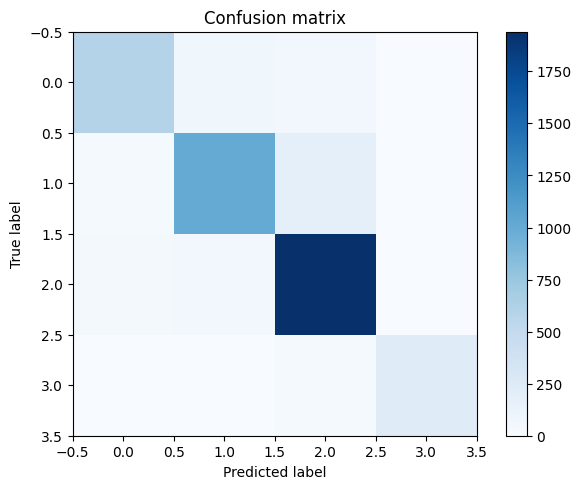

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 首先我们需要预测所有测试集的标签，以便创建混淆矩阵
@torch.no_grad()
def get_all_preds_and_targets(model, data_loader, device):
    all_preds = torch.tensor([]).to(device)
    all_targets = torch.tensor([]).to(device)
    for data in data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_targets = torch.cat((all_targets, labels), dim=0)
    return all_preds, all_targets

# 获取预测的类别和真实的类别
all_preds, all_targets = get_all_preds_and_targets(model, val_loader, device)
_, pred_classes = all_preds.max(dim=1)

# 创建混淆矩阵
cf_matrix = confusion_matrix(all_targets.cpu().numpy(), pred_classes.cpu().numpy())
print('Confusion Matrix:')
print(cf_matrix)

# 画出混淆矩阵
plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_tensorboard_log(path):
    # 加载日志数据
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    # 显示所有可以获取的数据键
    print(event_acc.Tags())

    # 获取并打印 precision、recall、FPR 和识别准确度的数据
    precision = event_acc.Scalars('train_precision')
    recall = event_acc.Scalars('train_recall')
    fpr = event_acc.Scalars('train_fpr')
    acc = event_acc.Scalars('train_acc')

    # 显示最终的 precision、recall、FPR 和 Accuracy
    print(f"Final Precision: {precision[-1].value}")
    print(f"Final Recall: {recall[-1].value}")
    print(f"Final FPR: {fpr[-1].value}")
    print(f"Final Accuracy: {acc[-1].value}")

# 假设我们的 tensorboard 日志路径是 './runs/CNN/your_time_folder'
tensorboard_log_dir = './runs/CNN/Jun06_07-57-01'
plot_tensorboard_log(tensorboard_log_dir)


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'learning_rate', 'train_precision', 'train_recall', 'train_fpr', 'val_precision', 'val_recall', 'val_fpr'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
Final Precision: 0.610902726650238
Final Recall: 0.5068568587303162
Final FPR: 0.38909727334976196
Final Accuracy: 0.6481426954269409
